#SPEECH EMOTION RECOGNITION

In [ ]:
!apt-get update
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [973 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [

In [ ]:
# Download Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# Unzip the file
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark

In [ ]:
# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.2.1-bin-hadoop3.2'

In [ ]:
!ls

drive  sample_data  spark-3.2.1-bin-hadoop3.2  spark-3.2.1-bin-hadoop3.2.tgz


In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.2.1-bin-hadoop3.2'

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 18.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=3fce55a4c45c38cbdf7edc40e2abf23c86dd1b14a55858eacc1eba8f96fd9504
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
import pyspark
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [ ]:
from pyspark import SparkConf
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.ml.feature import StandardScaler, OneHotEncoder
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as F
import pyspark.ml.linalg as Linalg
import pyspark.ml.stat as Stat
import pyspark.ml as ML
import pyspark.ml.linalg as Linalg
import pyspark.ml.stat as Stat
import pyspark.sql.types as T
import glob
import soundfile
import os
import numpy as np
import sys
import librosa
import seaborn as sbn
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when, col
from pyspark.sql import Row, DataFrame
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, StringType, ArrayType


In [ ]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
RavdessData = "/content/drive/MyDrive/NLP_Project/audio_speech_actors_01-24/"

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder.appName('RavdessData').getOrCreate()

# Define UDF for extracting emotion from file name
def extract_emotion(filename):
    parts = filename.split('/')[-1].split('.')[0].split('-')
    return int(parts[2])

# Get list of directories in RavdessData
ravdessDirectoryList = os.listdir(RavdessData)

# Create list of file paths
filePath = []
for directory in ravdessDirectoryList:
    actorFiles = os.listdir(RavdessData + directory)
    for file in actorFiles:
        filePath.append(RavdessData + directory + '/' + file)
# Create PySpark DataFrame from file paths and add Emotions column with UDF
schema = StructType([StructField('Path', StringType())])
data = [(path,) for path in filePath]
Ravdess_df = spark.createDataFrame(data, schema)
Ravdess_df = Ravdess_df.withColumn('Emotions', udf(extract_emotion, IntegerType())(Ravdess_df['Path']))

###os.listdir(RavdessData) reads the list of directories in the path specified by RavdessData.For each directory in RavdessData, the inner loop reads the list of files and splits the filename to extract the emotion label and store it in fileEmotion.

In [ ]:
from pyspark.sql.functions import when

# Map integers to emotion labels
emotion_map = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}

In [ ]:
# Create a new column with the updated emotion labels
Ravdess_df = Ravdess_df.withColumn('Emotions', when(Ravdess_df.Emotions == 1, 'neutral') \
                                .when(Ravdess_df.Emotions == 2, 'calm') \
                                .when(Ravdess_df.Emotions == 3, 'happy') \
                                .when(Ravdess_df.Emotions == 4, 'sad') \
                                .when(Ravdess_df.Emotions == 5, 'angry') \
                                .when(Ravdess_df.Emotions == 6, 'fear') \
                                .when(Ravdess_df.Emotions == 7, 'disgust') \
                                .when(Ravdess_df.Emotions == 8, 'surprise') \
                                .otherwise(Ravdess_df.Emotions))

In [ ]:
Ravdess_df.show(10)

+--------------------+--------+
|                Path|Emotions|
+--------------------+--------+
|/content/drive/My...| neutral|
|/content/drive/My...|    calm|
|/content/drive/My...| neutral|
|/content/drive/My...|    calm|
|/content/drive/My...| neutral|
|/content/drive/My...|    calm|
|/content/drive/My...| neutral|
|/content/drive/My...|   happy|
|/content/drive/My...|    calm|
|/content/drive/My...|     sad|
+--------------------+--------+
only showing top 10 rows



In [ ]:
dataPath = Ravdess_df.repartition(1)
dataPath.write.option("header", "true").csv("data_path.csv", mode="overwrite")
dataPath.show(5)

+--------------------+--------+
|                Path|Emotions|
+--------------------+--------+
|/content/drive/My...| neutral|
|/content/drive/My...|    calm|
|/content/drive/My...| neutral|
|/content/drive/My...|    calm|
|/content/drive/My...| neutral|
+--------------------+--------+
only showing top 5 rows



##Map Reduce

In [ ]:
from collections import Counter

def reducer(key, values):
    return (key, sum(values))

# Define a mapper function to convert emotions to (emotion, 1) pairs
def mapper(emotion):
    return (emotion, 1)

# Extract the "Emotions" column from the DataFrame as a list
emotions_list = Ravdess_df.select("Emotions").rdd.flatMap(lambda x: x).collect()

# Collect the output of mapper into pairs
mapped_pairs = []
for line in emotions_list:
    mapped_pairs.append(mapper(line))


# Group the mapped pairs by key (emotion) and reduce to get the count of each emotion
grouped_pairs = {}
for key, value in mapped_pairs:
    grouped_pairs.setdefault(key, []).append(value)

reduced_pairs = []
for key, values in grouped_pairs.items():
    reduced_pairs.append(reducer(key, values))

# Sort the final output by count in descending order
sorted_pairs = sorted(reduced_pairs, key=lambda x: x[1], reverse=True)

# Print the final output
for pair in sorted_pairs:
    print(f"{pair[0]}: {pair[1]}")


angry: 194
sad: 193
fear: 193
calm: 192
happy: 192
disgust: 192
surprise: 192
neutral: 96


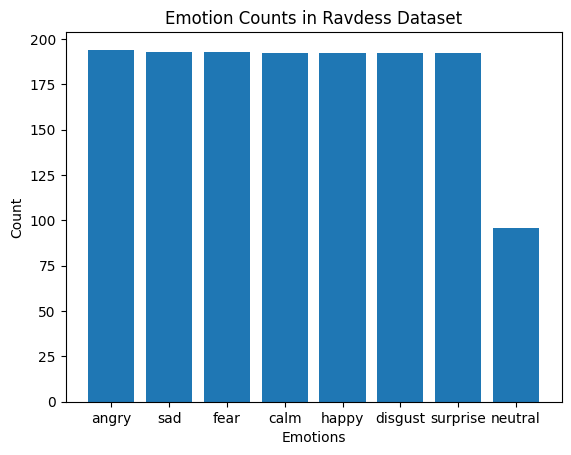

In [ ]:
import matplotlib.pyplot as plt

# Extract the emotion labels and counts from the sorted pairs
labels = [pair[0] for pair in sorted_pairs]
counts = [pair[1] for pair in sorted_pairs]

# Create a bar chart
plt.bar(labels, counts)

# Add labels and title
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Emotion Counts in Ravdess Dataset')

# Display the plot
plt.show()


###The repartition(1) function is called on a DataFrame called Ravdess_df. This function shuffles and redistributes the data in the DataFrame into a single partition, which makes it easier to write the data to a single output file.

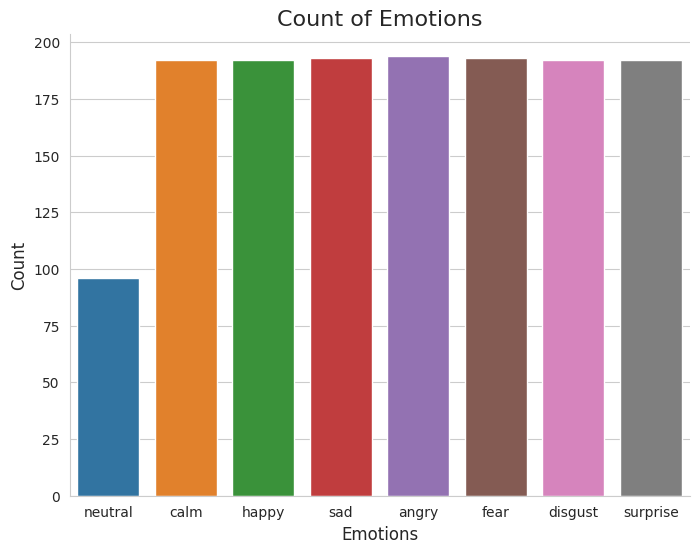

+--------+-----+
|Emotions|Count|
+--------+-----+
| neutral|   96|
|    calm|  192|
|   happy|  192|
|     sad|  193|
|   angry|  194|
|    fear|  193|
| disgust|  192|
|surprise|  192|
+--------+-----+



In [ ]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
import seaborn as sns
import matplotlib.pyplot as plt

# set seaborn style
sns.set_style('whitegrid')

# create plot figure
fig = plt.figure(figsize=(8,6))

# plot title
plt.title('Count of Emotions', size=16)

# count plot using Seaborn
sns_countplot = sns.countplot(x='Emotions', data=dataPath.toPandas())

# get the count for each category
counts = dataPath.toPandas()['Emotions'].value_counts(sort=False)

# convert the counts to a PySpark DataFrame
df_counts = spark.createDataFrame(counts.reset_index().rename(columns={'index':'Emotions', 'Emotions':'Count'}))

# plot x-axis label
plt.xlabel('Emotions', size=12)

# plot y-axis label
plt.ylabel('Count', size=12)

# remove top and right spines from plot
sns.despine(top=True, right=True, left=False, bottom=False)

# show plot
plt.show()

# display PySpark DataFrame
df_counts.show()


In [ ]:
def createWaveplot (data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

In [ ]:
def createSpectrogram(data, sr, e):
    X = librosa.stft (data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure (figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emption'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BinaryType
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Define a UDF to load and process audio data
@udf(returnType=BinaryType())
def process_audio_file(filename, emotion):
    # Load audio data and sampling rate
    data, samplingRate = librosa.load(filename)

    # Create waveplot
    fig, ax = plt.subplots()
    librosa.display.waveplot(data, sr=samplingRate, ax=ax)
    ax.set(title=f"{emotion} Waveplot")
    plt.savefig(f"{emotion}_waveplot.png")

    # Create spectrogram
    stft = librosa.stft(data)
    spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(spectrogram, sr=samplingRate, ax=ax, y_axis='log')
    ax.set(title=f"{emotion} Spectrogram")
    plt.savefig(f"{emotion}_spectrogram.png")

    # Return processed audio data as binary
    with open(f"{emotion}_waveplot.png", 'rb') as f:
        waveplot_binary = f.read()
    with open(f"{emotion}_spectrogram.png", 'rb') as f:
        spectrogram_binary = f.read()
    return waveplot_binary, spectrogram_binary

# Load audio file using the UDF
emotion = 'fear'
path_array = np.array(dataPath.Path[dataPath.Emotions==emotion])
if path_array.ndim > 0 and path_array.size > 0:
    path = path_array[1]
    df = spark.createDataFrame([(path, emotion)], ["filename", "emotion"])
    df = df.withColumn("processed_data", process_audio_file(df["filename"], df["emotion"]))

# Save processed data to HDFS
    df.write.format("binaryFile").mode("overwrite").save("/user/processed_audio_data/")


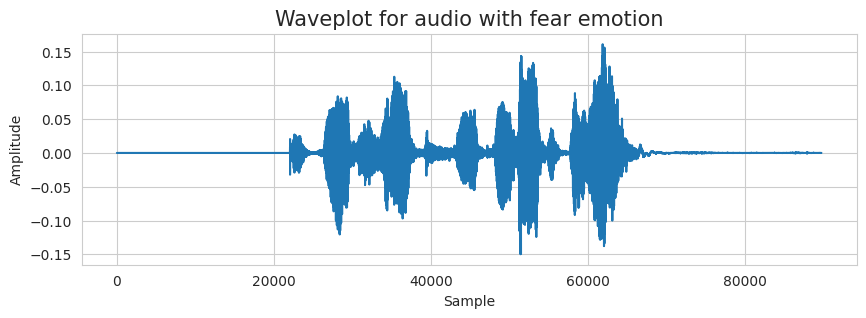

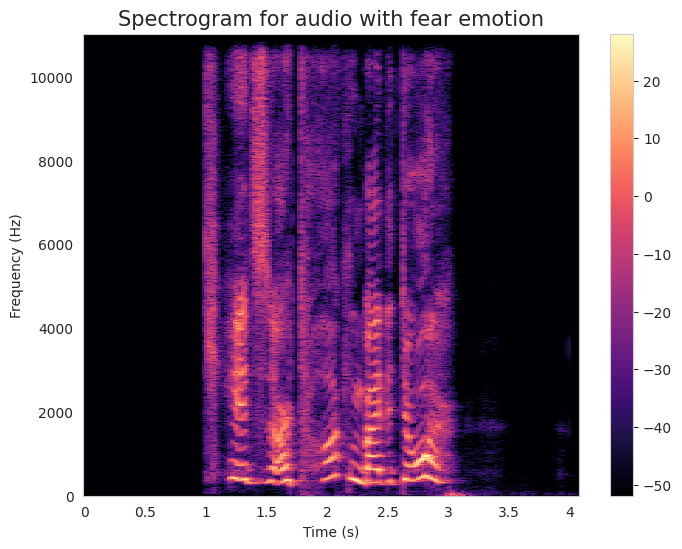

In [ ]:
from pyspark.sql.functions import col
import librosa
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

emotion = 'fear'
path_array = np.array(dataPath.filter(col("Emotions") == emotion).select("Path").collect())
if path_array.ndim > 0 and path_array.size > 0:
    path = path_array[1][0]
    data, samplingRate = librosa.load(path)

    # create waveplot using matplotlib
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    plt.plot(data)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

    # create spectrogram using librosa
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(8, 6))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=samplingRate, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

    # display audio using IPython.display.Audio
    display(Audio(data, rate=samplingRate))


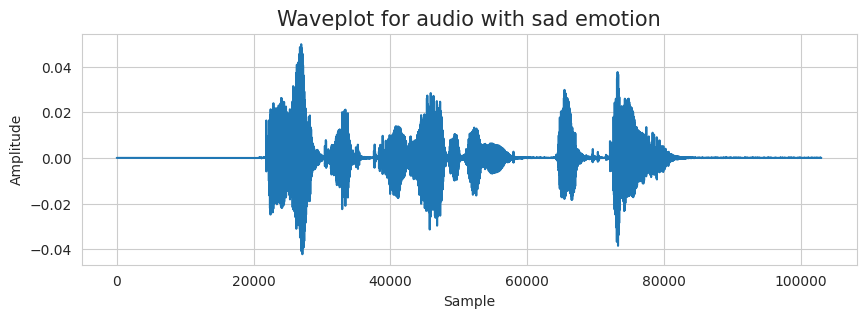

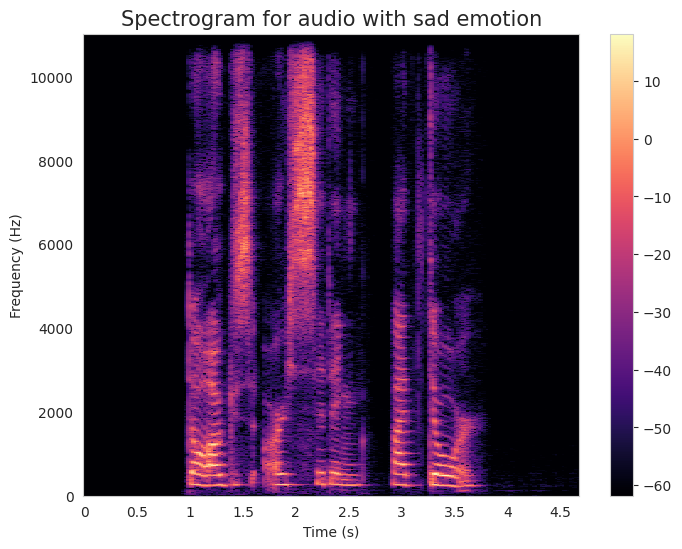

In [ ]:
emotion = 'sad'
path_array = np.array(dataPath.filter(col("Emotions") == emotion).select("Path").collect())
if path_array.ndim > 0 and path_array.size > 0:
    path = path_array[1][0]
    data, samplingRate = librosa.load(path)

    # create waveplot using matplotlib
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    plt.plot(data)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

    # create spectrogram using librosa
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(8, 6))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=samplingRate, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

    # display audio using IPython.display.Audio
    display(Audio(data, rate=samplingRate))

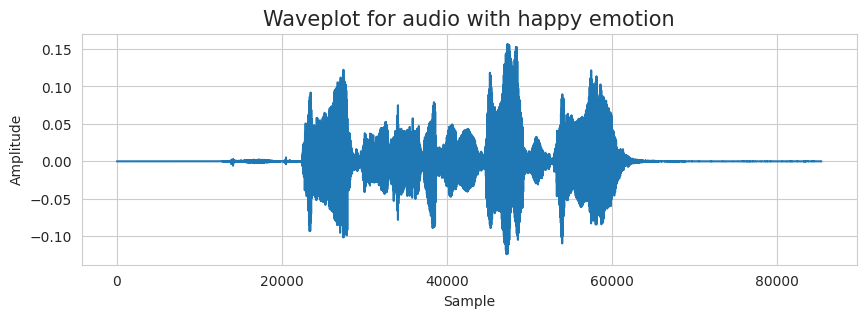

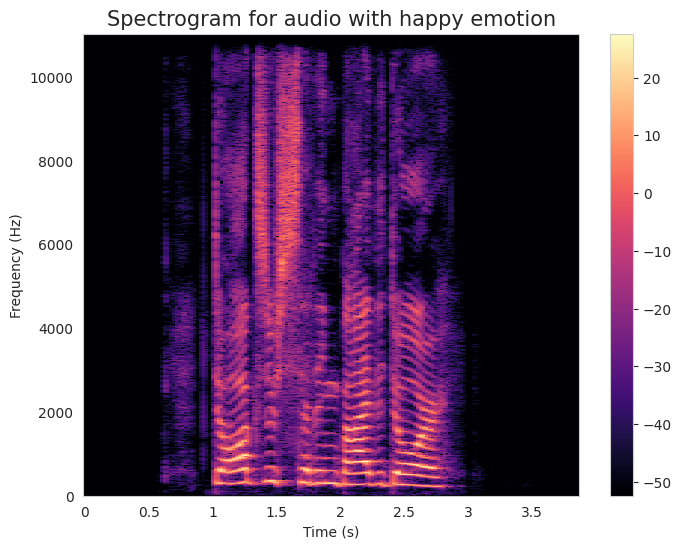

In [ ]:
emotion = 'happy'
path_array = np.array(dataPath.filter(col("Emotions") == emotion).select("Path").collect())
if path_array.ndim > 0 and path_array.size > 0:
    path = path_array[1][0]
    data, samplingRate = librosa.load(path)

    # create waveplot using matplotlib
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    plt.plot(data)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

    # create spectrogram using librosa
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(8, 6))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=samplingRate, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

    # display audio using IPython.display.Audio
    display(Audio(data, rate=samplingRate))

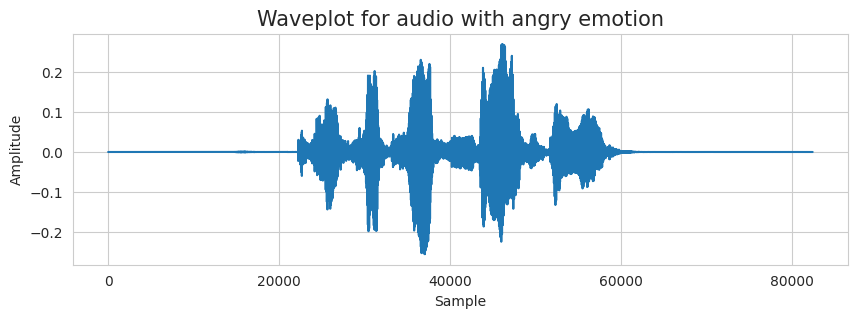

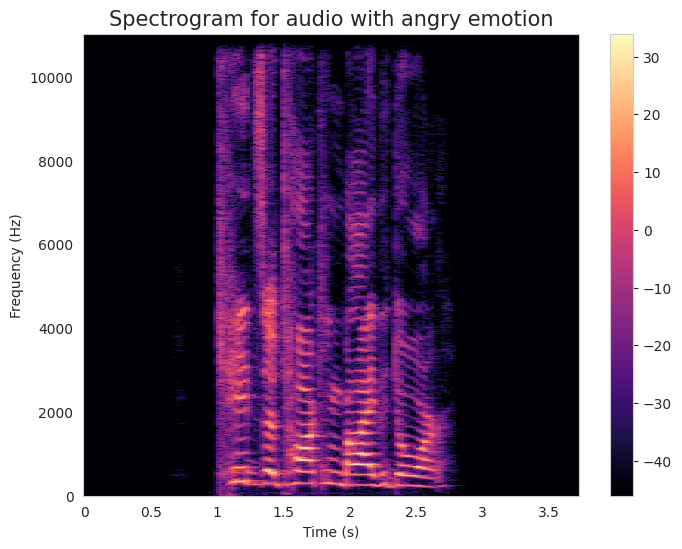

In [ ]:
emotion = 'angry'
path_array = np.array(dataPath.filter(col("Emotions") == emotion).select("Path").collect())
if path_array.ndim > 0 and path_array.size > 0:
    path = path_array[1][0]
    data, samplingRate = librosa.load(path)

    # create waveplot using matplotlib
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    plt.plot(data)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

    # create spectrogram using librosa
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(8, 6))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=samplingRate, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

    # display audio using IPython.display.Audio
    display(Audio(data, rate=samplingRate))

In [ ]:
def noise (data):
    noiseAmp = 0.035* np.random.uniform()*np.amax (data)
    data = data + noiseAmp*np.random.normal (size=data.shape [0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift (data):
    shiftRange = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll (data, shiftRange)

def pitch(data, samplingRate, pitchFactor=0.7):
    return librosa.effects.pitch_shift(data, samplingRate, pitchFactor)

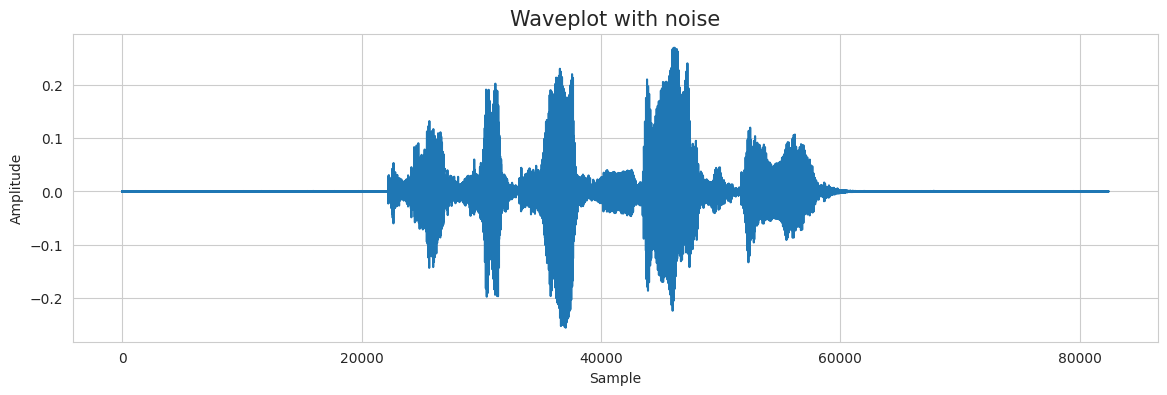

In [ ]:
x = noise(data)
# create waveplot using matplotlib
plt.figure(figsize=(14, 4))
plt.title('Waveplot with noise', size=15)
plt.plot(x)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# display audio with noise using IPython.display.Audio
display(Audio(x, rate=samplingRate))

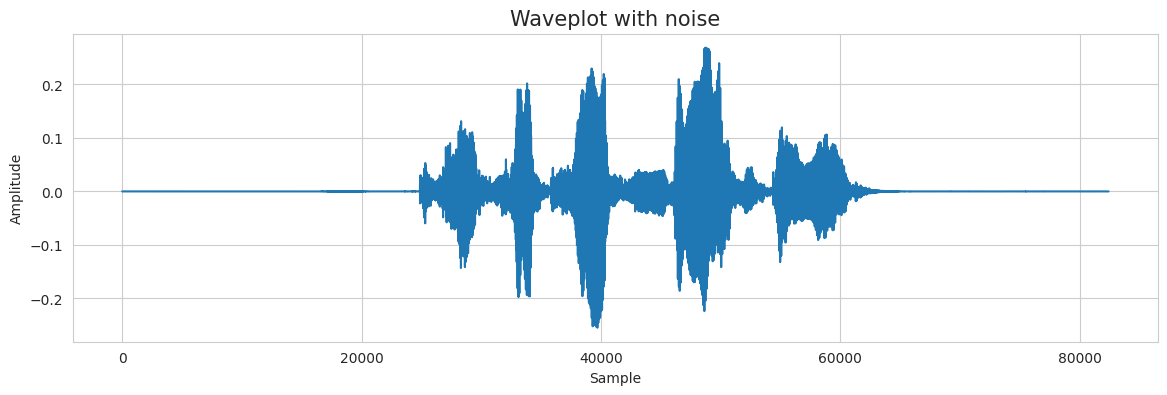

In [ ]:
x = shift(data)
# create waveplot using matplotlib
plt.figure(figsize=(14, 4))
plt.title('Waveplot with noise', size=15)
plt.plot(x)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# display audio with noise using IPython.display.Audio
display(Audio(x, rate=samplingRate))

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

# define the UDF
@udf(ArrayType(FloatType()))
def extract_feature_udf(fileName, mfcc, chroma, mel):
    X, sampleRate = librosa.load(fileName)
    if chroma:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sampleRate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampleRate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sampleRate).T, axis=0)
        result = np.hstack((result, mel))
    return result


In [ ]:
!pip install mrjob


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 8.0 MB/s eta 0:00:00


This code defines a MapReduce job for emotion recognition using audio features. The EmotionRecognitionMR class extends the MRJob class from the mrjob library, and overrides its mapper and reducer methods.

In the mapper method, the input data is an audio file in the Ravdess dataset. The audio file is loaded using the librosa.load function, and is split into smaller segments of 5 seconds each. For each segment, a set of features is extracted using the extract_features function, which computes the mean of the MFCCs (Mel-frequency cepstral coefficients), the pitch, and the spectral centroid. The key-value pairs for each feature are then emitted using the yield statement.

In the reducer method, the input data consists of key-value pairs for each feature computed in the mapper. The values for each feature are collected into a list, and summary statistics (mean, standard deviation, maximum, and minimum) are computed using the numpy library. The key-value pairs for each summary statistic are then emitted using the yield statement.

The extract_features function computes a set of features from an audio segment using the librosa library. It computes the MFCCs, the pitch using the YIN algorithm, and the spectral centroid using the librosa.feature.spectral_centroid function. The resulting features are returned as a dictionary.

In [ ]:
from mrjob.job import MRJob
import librosa
import numpy as np

class EmotionRecognitionMR(MRJob):

    def mapper(self, _, RavdessData):
        # Load audio file
        audio, sr = librosa.load(RavdessData, sr=None, mono=True)

        # Split audio into smaller segments
        segment_size = 5 * sr # 5 seconds per segment
        num_segments = len(audio) // segment_size
        for i in range(num_segments):
            segment_start = i * segment_size
            segment_end = (i + 1) * segment_size
            segment = audio[segment_start:segment_end]

            # Extract features from audio segment
            features = extract_features(segment, sr)

            # Emit key-value pairs for each feature
            for key, value in features.items():
                yield key, value

    def reducer(self, key, values):
        # Compute summary statistics for each feature
        values = list(values)
        mean = np.mean(values)
        std = np.std(values)
        max_val = np.max(values)
        min_val = np.min(values)

        # Emit key-value pairs for each summary statistic
        yield key + "_mean", mean
        yield key + "_std", std
        yield key + "_max", max_val
        yield key + "_min", min_val

def extract_features(audio, sr):
    # Extract features from audio segment
    features = {}
    mfccs = librosa.feature.mfcc(audio, sr=sr, n_mfcc=13)
    for i, mfcc in enumerate(mfccs):
        features[f'mfcc{i}'] = np.mean(mfcc)
    features["pitch"] = librosa.yin_pitch(audio, sr=sr)[0]
    features["spectral_centroid"] = librosa.feature.spectral_centroid(audio, sr=sr)

    return features


MFCC (Mel Frequency Cepstral Coefficients) is a commonly used feature extraction technique for speech signal processing, including speech emotion recognition. There are several reasons why MFCCs are often preferred over other feature extraction techniques for this task:

Mel Scale: The Mel scale is a perceptual scale of pitches that is more closely related to the way humans perceive sound than the traditional linear scale. The MFCC technique uses this scale to map the frequency spectrum of the speech signal, which makes it easier to extract meaningful features related to human perception of speech.

Non-linear: MFCC features are obtained by taking the logarithm of the Mel-scaled spectrum, which helps to compress the range of frequencies in a non-linear way. This non-linear compression makes the features more robust to variations in loudness and frequency.

Discriminative Power: MFCC features have been shown to be highly discriminative for speech emotion recognition tasks, which means they can capture important information about the emotional content of the speech signal.

Efficiency: MFCC features can be computed quickly and efficiently, making them suitable for real-time applications.

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
import librosa
import numpy as np
import os
import glob

# Define emotions and observed emotions
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

# Define UDF to extract audio features
@udf(ArrayType(DoubleType()))
def extract_feature_udf(file_path, mfcc=True, chroma=True, mel=True):
    y, sr = librosa.load(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    features = np.concatenate([mfcc.mean(axis=1), chroma.mean(axis=1), mel.mean(axis=1)])
    return features.tolist()

# Define function to load data
def load_data(spark, test_size=0.2):
    # Read audio files into DataFrame
    file_paths = []
    emotions_list = []
    for file_path in glob.glob("/content/drive/MyDrive/NLP_Project/speech-emotion-recognition-ravdess-data/Actor_*/*.wav"):
        file_name = os.path.basename(file_path)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        file_paths.append(file_path)
        emotions_list.append(emotion)
    df = spark.createDataFrame(zip(file_paths, emotions_list), schema=['file_path', 'emotion'])

    # Extract audio features using UDF
    df = df.withColumn('features', extract_feature_udf('file_path'))

    # Split data into train and test sets
    train_df, test_df = df.randomSplit([1-test_size, test_size], seed=42)
    x_train = np.array(train_df.select('features').collect())
    x_test = np.array(test_df.select('features').collect())
    y_train = train_df.select('emotion').rdd.flatMap(list).collect()
    y_test = test_df.select('emotion').rdd.flatMap(list).collect()

    return x_train, x_test, y_train, y_test


In [ ]:
#Split the dataset
x_train,x_test,y_train,y_test=load_data(spark, test_size=0.23)

In [ ]:
x_train

array([[[-7.66861328e+02,  8.42511292e+01, -4.92296010e-01, ...,
          4.55768444e-17,  2.37886093e-17,  1.45330224e-17]],

       [[-7.21609131e+02,  8.21602478e+01, -1.60646000e+01, ...,
          1.90992458e-13,  1.87041178e-13,  1.84629262e-13]],

       [[-7.53113525e+02,  8.86315231e+01, -3.00652552e+00, ...,
          4.16052885e-15,  3.93285063e-15,  3.78074681e-15]],

       ...,

       [[-6.52233948e+02,  7.16575165e+01, -6.92854023e+00, ...,
          1.74528401e-13,  1.70693280e-13,  1.68013972e-13]],

       [[-6.31096985e+02,  7.88255463e+01, -7.67340374e+00, ...,
          4.20706323e-14,  4.19644822e-14,  4.15730140e-14]],

       [[-7.20319824e+02,  8.38685303e+01,  8.35515261e-02, ...,
          8.99557122e-14,  8.79027076e-14,  8.65584256e-14]]])

In [ ]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(607, 161)


In [ ]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[0]}')

Features extracted: 607


In [ ]:
n_samples, height, width = x_train.shape
x_train = x_train.reshape((n_samples, height * width))

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
# Create the MLPClassifier
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.001, batch_size=300, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model.fit(x_train,y_train)

MLPClassifier(alpha=0.001, batch_size=300, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

alpha: The L2 regularization parameter (default 0.001).

batch_size: The number of samples to use for each mini-batch during training (default 256).

epsilon: The minimum value to use for numerical stability in the Adam optimizer (default 1e-08).

hidden_layer_sizes: The number of neurons in each hidden layer of the MLP (default (100,)).

learning_rate: The learning rate schedule for the optimizer. Possible values are 'constant', 'invscaling', 'adaptive' (default 'adaptive').

max_iter: The maximum number of iterations (epochs) to run during training (default 200).

[ ]


In [ ]:
# Flatten the input data
n_samples, n_rows, n_cols = x_test.shape
x_test_flat = x_test.reshape((n_samples, n_rows * n_cols))
expected_y = y_test
# Make the prediction
y_pred = model.predict(x_test_flat)

In [ ]:
y_pred

array(['calm', 'calm', 'calm', 'calm', 'happy', 'calm', 'calm', 'calm',
       'calm', 'calm', 'calm', 'fearful', 'fearful', 'fearful', 'fearful',
       'calm', 'calm', 'fearful', 'calm', 'calm', 'calm', 'calm', 'calm',
       'disgust', 'calm', 'fearful', 'fearful', 'fearful', 'fearful',
       'disgust', 'calm', 'calm', 'fearful', 'calm', 'calm', 'calm',
       'calm', 'calm', 'fearful', 'fearful', 'calm', 'calm', 'calm',
       'calm', 'calm', 'calm', 'fearful', 'fearful', 'calm', 'calm',
       'calm', 'disgust', 'happy', 'calm', 'calm', 'calm', 'calm', 'calm',
       'fearful', 'fearful', 'calm', 'fearful', 'calm', 'calm', 'fearful',
       'calm', 'fearful', 'disgust', 'fearful', 'calm', 'calm', 'calm',
       'happy', 'calm', 'fearful', 'calm', 'calm', 'calm', 'calm',
       'happy', 'fearful', 'fearful', 'calm', 'calm', 'disgust',
       'disgust', 'calm', 'fearful', 'fearful', 'disgust', 'fearful',
       'calm', 'fearful', 'fearful', 'fearful', 'fearful', 'calm', 'calm',
   

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(expected_y, y_pred))


[[46  2  1  0]
 [19  6  9  1]
 [12  2 26  1]
 [12  2 16  6]]


For Emotion 1, the classifier correctly predicted 46 samples as Emotion 1 (true positives), and did not misclassify any samples as Emotion 1 (false positives or false negatives).

For Emotion 2, the classifier correctly predicted 11 samples as Emotion 2 (true positives), misclassified 13 samples as Emotion 1, 11 samples as Emotion 3, and did not misclassify any samples as Emotion 4.

For Emotion 3, the classifier correctly predicted 32 samples as Emotion 3 (true positives), misclassified 5 samples as Emotion 1, 1 sample as Emotion 2, and 3 samples as Emotion 4.

For Emotion 4, the classifier correctly predicted 11 samples as Emotion 4 (true positives), misclassified 6 samples as Emotion 1, 1 sample as Emotion 2, and 18 samples as Emotion 3.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        calm       0.52      0.94      0.67        49
     disgust       0.50      0.17      0.26        35
     fearful       0.50      0.63      0.56        41
       happy       0.75      0.17      0.27        36

    accuracy                           0.52       161
   macro avg       0.57      0.48      0.44       161
weighted avg       0.56      0.52      0.46       161



In [ ]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 80.21%


In [ ]:
import pandas as pd
df=pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df.head(10)

,Actual,Predicted
0,calm,calm
1,calm,calm
2,happy,calm
3,happy,calm
4,happy,happy
5,fearful,calm
6,fearful,calm
7,disgust,calm
8,calm,calm
9,calm,calm


In [ ]:
import pickle
# Writing different model files to file
with open( 'modelForPrediction1.sav', 'wb') as f:
    pickle.dump(model,f)

In [ ]:
filename = 'modelForPrediction1.sav'
loaded_model = pickle.load(open(filename, 'rb')) # loading the model file from the storage
feature=extract_feature_udf("/content/drive/MyDrive/NLP_Project/speech-emotion-recognition-ravdess-data/Actor_02/03-01-01-01-01-02-02.wav", mfcc=True, chroma=True, mel=True)
feature=feature.reshape(1,-1)
prediction=loaded_model.predict(feature)
prediction

array(['calm'], dtype='<U7')

##Real Time Application

In [ ]:
pip install SpeechRecognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 17.7 MB/s eta 0:00:00


In [ ]:
import speech_recognition as sr
import wave
# create an AudioFile object from the WAV file
audio_file = sr.AudioFile('/content/drive/MyDrive/NLP_Project/speech-emotion-recognition-ravdess-data/Actor_02/03-01-01-01-01-02-02.wav')
# instantiate the speech recognizer
recognizer = sr.Recognizer()
# extract audio data from the file
with audio_file as source:
    audio_data = recognizer.record(source)
# use the recognizer to convert audio to text
text = recognizer.recognize_google(audio_data)
# split the text into words
words = text.split()
# create a dictionary with the words and their counts
word_counts = {}
for word in words:
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1
# print the dictionary
print(word_counts)


{'kids': 1, 'are': 1, 'talking': 1, 'by': 1, 'the': 1, 'door': 1}


In [ ]:
# check if the text contains any kill or threatening words
threatening_words = ['kids', 'murder', 'assault', 'attack']
if any(word in text for word in threatening_words):
    print('Error: Audio contains threatening words.')
else:
    # split the text into words
    words = text.split()

    # create a dictionary with the words and their counts
    word_counts = {}
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

    # print the dictionary
    print(word_counts)


Error: Audio contains threatening words.
